In [1]:
# %env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
# !echo $DRJIT_LIBLLVM_PATH

In [2]:
# %%bash
# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [3]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

In [4]:
from furnace_scene import make_scene_uniform, visualize_scene
import numpy as np

color_ref = [0.2, 0.25, 0.7]
scene = make_scene_uniform(color_ref)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1504577..3.3427365].


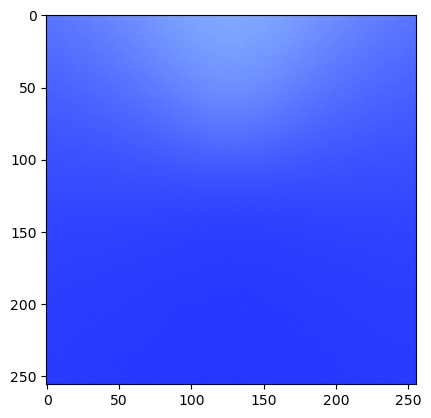

In [5]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [6]:
from radiosity_rt import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss

NUM_WI_DIRECTIONS = 32
SAMPLES_PER_RAY_LI = 32
SAMPLES_PER_RAY_LO = 128
NUM_GEO_SAMPLES = 1 << 12

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


In [7]:
from train import define_BSDF_diffuse_textured

# Initialize BSDF to train
bsdf_train, keys = define_BSDF_diffuse_textured(tex_size=(64, 64))
params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(100):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    # print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.050178]: Loss = [0.350216]
Iteration 002 [0.035484]: Loss = [0.254735]
Iteration 003 [0.035470]: Loss = [0.177532]
Iteration 004 [0.033875]: Loss = [0.122629]
Iteration 005 [0.032568]: Loss = [0.0743526]
Iteration 006 [0.032886]: Loss = [0.0538401]
Iteration 007 [0.034771]: Loss = [0.0382119]
Iteration 008 [0.033036]: Loss = [0.0393683]
Iteration 009 [0.033164]: Loss = [0.0428964]
Iteration 010 [0.033449]: Loss = [0.0441035]
Iteration 011 [0.032909]: Loss = [0.0500682]
Iteration 012 [0.033051]: Loss = [0.0532155]
Iteration 013 [0.033093]: Loss = [0.0511602]
Iteration 014 [0.032907]: Loss = [0.0495576]
Iteration 015 [0.033267]: Loss = [0.0458775]
Iteration 016 [0.033285]: Loss = [0.0412105]
Iteration 017 [0.033166]: Loss = [0.0371894]
Iteration 018 [0.033672]: Loss = [0.0320132]
Iteration 019 [0.033054]: Loss = [0.0293297]
Iteration 020 [0.033240]: Loss = [0.0252891]
Iteration 021 [0.033282]: Loss = [0.0239579]
Iteration 022 [0.033832]: Loss = [0.0219784]
Iteration 023 

Reference albedo: [0.2, 0.25, 0.7]
Optimized albedo: [0.199378, 0.249249, 0.691128]


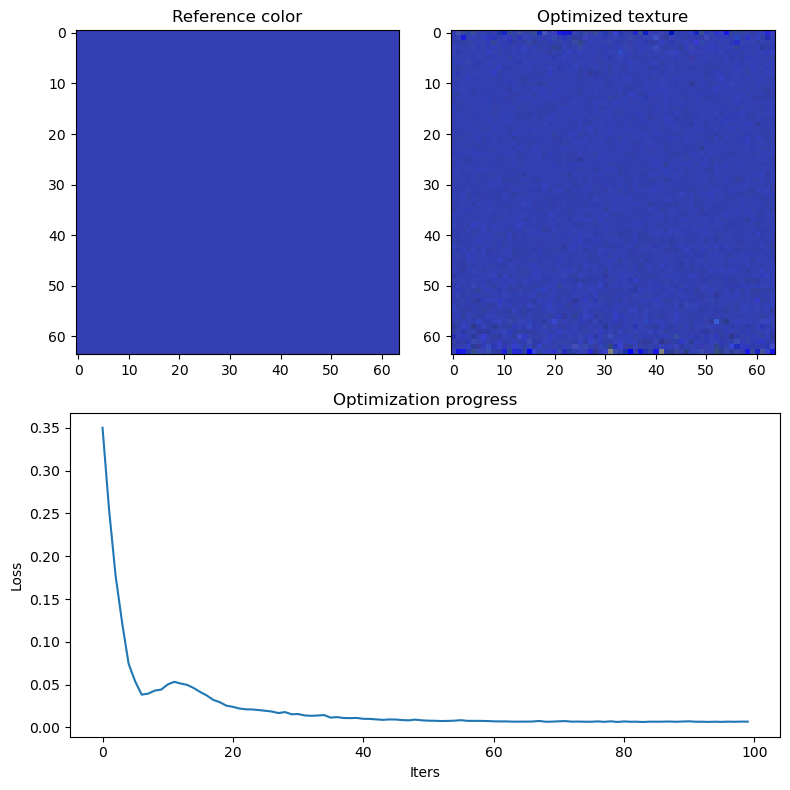

In [8]:
import matplotlib.pyplot as plt
from drjit.auto import Array3f

texture_key = keys[0]
texture_out = params[texture_key]

print("Reference albedo:", color_ref)
print("Optimized albedo:", dr.mean(texture_out, axis=(0,1)))

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title("Reference color")
plt.imshow(np.full((64, 64, 3), np.array(color_ref)))
plt.subplot(222)
plt.title("Optimized texture")
plt.imshow(texture_out)

plt.subplot(212)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.tight_layout()